# Skin Cancer Detector with HAM10000

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import glob
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sbn
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator



IMG_WIDTH = 64
IMG_HEIGHT = 64

## Load the data and preprocessing
The dataset contains 10015 images divided in two parts. The 'HAM10000_metadata.csv' contains the ground truth of the dataset. Here we can use this file to retrieve the images from the relative folders and also analyse what the images are.

In [3]:
path = '.'
file_name = os.path.join(path, 'HAM10000_metadata.csv')
df = pd.read_csv(file_name, na_values=['NA','?'])
disease_types = pd.unique(df['dx'])
print(disease_types)

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


As you can see from the last print, there are 7 types of images classified in the dataset. Let's create a dictionary to better represent those diseases and then replace those with the full name of the skin patology.

In [4]:
images_type = {'bkl': 'Benign_Keratosis', 'nv': 'Melanocytic_Nevi',
                      'df': 'Dermatofibroma', 'mel': 'Melanoma',
                      'vasc': 'Vascular_Lesions', 'bcc': 'Basal_Cell_Carcinoma',
                      'akiec': "Bowens_disease"}
images_type
df.replace(images_type.keys(), images_type.values(), inplace=True)
df[:5]

lesion_id      image_id                dx dx_type   age   sex  \
0  HAM_0000118  ISIC_0027419  Benign_Keratosis   histo  80.0  male   
1  HAM_0000118  ISIC_0025030  Benign_Keratosis   histo  80.0  male   
2  HAM_0002730  ISIC_0026769  Benign_Keratosis   histo  80.0  male   
3  HAM_0002730  ISIC_0025661  Benign_Keratosis   histo  80.0  male   
4  HAM_0001466  ISIC_0031633  Benign_Keratosis   histo  75.0  male   

  localization  
0        scalp  
1        scalp  
2        scalp  
3        scalp  
4          ear

In [5]:
# We can observe also that the ages range, varies between 0 and 80.
# This information will be useful in the final analysis 
# because we could tell wheter if the age is an increasing 
# factor of skin cancer or not.
age_range = pd.unique(df['age'])
age_range

array([80., 75., 60., 70., 55., 85., 65., 40., 50., 45., 35.,  0., 30.,
       nan,  5., 25., 20., 10., 15.])

In [6]:
# It is also possible to locate where different tumors where found in the 
# patients
cancers_location = pd.unique(df['localization'])
cancers_location

array(['scalp', 'ear', 'face', 'back', 'trunk', 'chest',
       'upper extremity', 'abdomen', 'unknown', 'lower extremity',
       'genital', 'neck', 'hand', 'foot', 'acral'], dtype=object)

The dataset has been developed during the last 20 years and most of the images have been classified manually using a process that in medicine is called 'Histopathology' (histo) which entails to microscopically analyse a small portion of the skin tissue and then classifying it accordigly. There are also images which has been classified by the use of a tool called Cofocal Microscopy (cofocal) which allowed medicians to correctly identify where there's a disease and where it's not. Finally the data contains also a series of images that have not been classified rigorously, denoted by 'follow_up' (data that needs follow-up examination) and 'consensus' data that has been classified by the consensus of a medician.

In [7]:
classification_type = pd.unique(df['dx_type'])
print(classification_type)

df[:5]


['histo' 'consensus' 'confocal' 'follow_up']


lesion_id      image_id                dx dx_type   age   sex  \
0  HAM_0000118  ISIC_0027419  Benign_Keratosis   histo  80.0  male   
1  HAM_0000118  ISIC_0025030  Benign_Keratosis   histo  80.0  male   
2  HAM_0002730  ISIC_0026769  Benign_Keratosis   histo  80.0  male   
3  HAM_0002730  ISIC_0025661  Benign_Keratosis   histo  80.0  male   
4  HAM_0001466  ISIC_0031633  Benign_Keratosis   histo  75.0  male   

  localization  
0        scalp  
1        scalp  
2        scalp  
3        scalp  
4          ear

After having deleted the pieces of data that are not relevant for the analysis, we now check if there are any missing values.

In [8]:
df.isnull().any()

lesion_id       False
image_id        False
dx              False
dx_type         False
age              True
sex             False
localization    False
dtype: bool

From the analysis, it appears that the column of the 'age' has some missing values. To solve this problem we decided to fill those missing values with the median value.

In [9]:
median = df['age'].median()
df['age'] = df['age'].fillna(median)
df.isnull().any()
df

lesion_id      image_id                dx dx_type   age     sex  \
0      HAM_0000118  ISIC_0027419  Benign_Keratosis   histo  80.0    male   
1      HAM_0000118  ISIC_0025030  Benign_Keratosis   histo  80.0    male   
2      HAM_0002730  ISIC_0026769  Benign_Keratosis   histo  80.0    male   
3      HAM_0002730  ISIC_0025661  Benign_Keratosis   histo  80.0    male   
4      HAM_0001466  ISIC_0031633  Benign_Keratosis   histo  75.0    male   
...            ...           ...               ...     ...   ...     ...   
10010  HAM_0002867  ISIC_0033084    Bowens_disease   histo  40.0    male   
10011  HAM_0002867  ISIC_0033550    Bowens_disease   histo  40.0    male   
10012  HAM_0002867  ISIC_0033536    Bowens_disease   histo  40.0    male   
10013  HAM_0000239  ISIC_0032854    Bowens_disease   histo  80.0    male   
10014  HAM_0003521  ISIC_0032258          Melanoma   histo  70.0  female   

      localization  
0            scalp  
1            scalp  
2            scalp  
3            scalp  
4              ear  
...            ...  
10010      abdomen  
10011      abdomen  
10012      abdomen  
10013         face  
10014         back  

[10015 rows x 7 columns]

After this brief pre-processing, we can see that there are 10015 images, each with a dimension of 600x450. We are going to reshape those images in a much scaled size 64x64 improve the performance in terms of speed of the model that we are going to build.

In [69]:
# Get the path of the original images directory
original_images_path = '/Users/tommasocapecchi/Datasets/HAM10000/Images/'
# Retrieve all the images path in the specified directory and store them into a list
images = [img for img in glob.glob(original_images_path+'*.jpg')]
# Create a new directory for the processed images
if not 'Processed_images' in os.listdir('/Users/tommasocapecchi/Datasets/HAM10000/'):
    os.mkdir('/Users/tommasocapecchi/Datasets/HAM10000/Processed_images')

# Iterate through all the images and names associated to open and resize those images. To open an image we are
# going to use the PIL library. Finally, save the new image in the previously created directory.
for img, name in zip(images, df['image_id']):
    data = Image.open(img)
    data = data.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
    data.save('/Users/tommasocapecchi/Datasets/HAM10000/Processed_images/'+name+'.jpg')

Now we update the dataframe, inserting a new column named 'image_path' that will specify for each image, the current path in the disk.

In [10]:
# Now it is useful to insert in the dataframe a column
# where for each image, locate the local path.
images_dir_path = '/Users/tommasocapecchi/Datasets/HAM10000/Processed_images/'
images_path = []
for image_name in df['image_id']:
    image_path = os.path.join(images_dir_path, image_name +'.jpg')
    images_path.append(image_path)

df['image_path'] = images_path
df[:5]

lesion_id      image_id                dx dx_type   age   sex  \
0  HAM_0000118  ISIC_0027419  Benign_Keratosis   histo  80.0  male   
1  HAM_0000118  ISIC_0025030  Benign_Keratosis   histo  80.0  male   
2  HAM_0002730  ISIC_0026769  Benign_Keratosis   histo  80.0  male   
3  HAM_0002730  ISIC_0025661  Benign_Keratosis   histo  80.0  male   
4  HAM_0001466  ISIC_0031633  Benign_Keratosis   histo  75.0  male   

  localization                                         image_path  
0        scalp  /Users/tommasocapecchi/Datasets/HAM10000/Proce...  
1        scalp  /Users/tommasocapecchi/Datasets/HAM10000/Proce...  
2        scalp  /Users/tommasocapecchi/Datasets/HAM10000/Proce...  
3        scalp  /Users/tommasocapecchi/Datasets/HAM10000/Proce...  
4          ear  /Users/tommasocapecchi/Datasets/HAM10000/Proce...

And finally we add another column called 'target', that will indeed contain the classification label for each image. As already shown, there are a total of 7 classes of skin cancer (values from 0 to 6)

In [29]:
# Identify the class of the skin cancer and encode them in a range of integers between [0-6].
encoder = preprocessing.LabelEncoder()
labels = encoder.fit_transform(df['dx']).reshape((-1,1))
df['target'] = labels
indices = np.random.permutation(len(df))
df = df.reindex(indices)
df.reset_index(drop=True, inplace=True)
df[:5]

lesion_id      image_id                dx    dx_type   age     sex  \
0  HAM_0003453  ISIC_0031508  Melanocytic_Nevi  follow_up  55.0  female   
1  HAM_0007177  ISIC_0025626  Melanocytic_Nevi  follow_up  30.0    male   
2  HAM_0002788  ISIC_0027563  Vascular_Lesions  consensus  70.0    male   
3  HAM_0004799  ISIC_0030807  Melanocytic_Nevi  follow_up  35.0  female   
4  HAM_0000891  ISIC_0027963  Melanocytic_Nevi      histo  30.0  female   

      localization                                         image_path  target  
0          abdomen  /Users/tommasocapecchi/Datasets/HAM10000/Proce...       4  
1            trunk  /Users/tommasocapecchi/Datasets/HAM10000/Proce...       4  
2  lower extremity  /Users/tommasocapecchi/Datasets/HAM10000/Proce...       6  
3  lower extremity  /Users/tommasocapecchi/Datasets/HAM10000/Proce...       4  
4  lower extremity  /Users/tommasocapecchi/Datasets/HAM10000/Proce...       4

Now we would like to count the numbers of skin cancers according to each category to see if the dataset is well balanced or not.

Now we are going to load the images and adapt them to the best of our possibilities with respect to the size. The images in the dataset comes with two directories, part-1 and part-2. We are going to retrieve those images in two different variables and then unify in one big piece of data.

In [12]:
instances_cancer = df['dx'].value_counts()
instances_cancer

Melanocytic_Nevi        6705
Melanoma                1113
Benign_Keratosis        1099
Basal_Cell_Carcinoma     514
Bowens_disease           327
Vascular_Lesions         142
Dermatofibroma           115
Name: dx, dtype: int64

From the results it appears that the dataset is highly imbalanced, thus we might consider some technique of expansion for those categories that suffer of a lack of instances with respect to those that have a high number instead. For the moment we are not augmenting any data, since we want to compare the performances of the model before and after data augmentation.

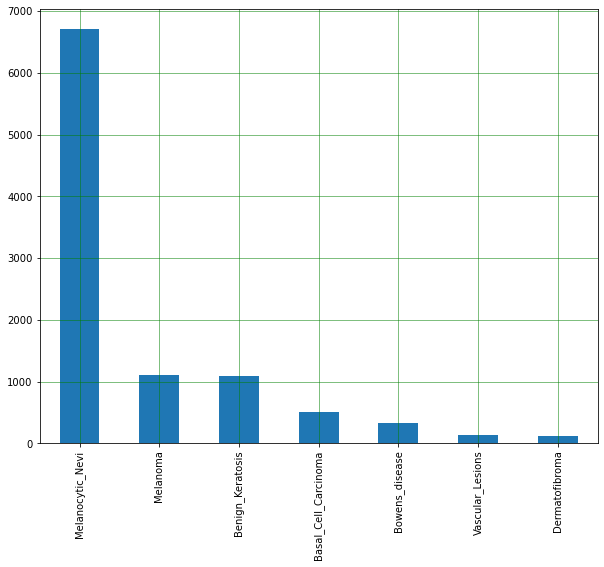

In [13]:
instances_cancer.plot(kind='bar', figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Now let's build the set of the images with the corresponding labels.

## Building the model: training and evaluation phase

We are now going to build the actual Convolutional Neural Network to solve the problem of correctly classify the various type of skin cancer. To achieve this goal, first we are going to create a basic implementation to get initial results, then we are going to modify and apply different techniques to improve performances. 

Firstly, we are going to get the actual data from the images. Since each image is a 64x64 image represented in colors, each image will have a shape of (64,64,3) where the final dimension refers to the RGB channel. Each pixel will have a value between 0 and 255.

In [37]:
X = []
y = []
# Iterate through the dataframe selecting the image path (to read the pixels value for each image)
# and the target value and store those information.
# into the 
for path_img, label in zip(df['image_path'].values, df['target'].values):
    img = plt.imread(path_img, format='rgb')
    X.append(img)
    y.append(label)
    
# Reshape the two list as numpy arrays. The X will have the shape (n_images, W, H, RGB)
X = np.array(X).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3)
y = np.array(y).reshape(-1, 1)
print(X.shape)

#It is also a good practice to normalize the values of each pixel into a range between 0 and 1
# to improve performances in the network.
X = np.asarray([x/255 for x in X])
X[:5]


#Let's now shuffle the data and create the train, test sample
indices = np.random.permutation(X.shape[0])
df = df.reindex(indices)
X = X[indices]
y = y[indices]

(10015, 64, 64, 3)


Now that the data is completely processed, we can split it into training and validation set using the sklearn library.

In [125]:
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Check splitting shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7511, 64, 64, 3)
(2504, 64, 64, 3)
(7511, 1)
(2504, 1)


Before building the model, let's print some of the images to verify that we scaled and shuffled properly the whole collection of the data.

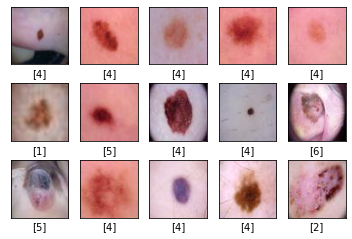

In [126]:
fig, axes= plt.subplots(3,5)
for i, axi in enumerate(axes.flat):
    axi.imshow(X[i])
    axi.set(xticks=[], yticks=[],
            xlabel=y[i])
    
plt.show()
plt.close()

Let's now build a naïve CNN to get some initial results and then let's try to adapt the CNN with a model that provides a higher performance.

In [142]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64,
                           kernel_size=(2, 2),
                           strides= 1,
                           padding='same',
                           input_shape=(64, 64, 3),
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
    ])

custom = opt.Adam()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=custom,
              metrics =['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 254016)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65028352  
_________________________________________________________________
dense_18 (Dense)             (None, 7)                 1799      
Total params: 65,030,983
Trainable params: 65,030,983
Non-trainable params: 0
_________________________________________________________________


In [143]:
history = model.fit(X_train, y_train, batch_size=100, verbose=1, epochs=10)

Epoch 1/10
76/76 [==============================] - 73s 961ms/step - loss: 3.5788 - accuracy: 0.6071
Epoch 2/10
76/76 [==============================] - 69s 910ms/step - loss: 1.1490 - accuracy: 0.6689
Epoch 3/10
76/76 [==============================] - 69s 908ms/step - loss: 1.1414 - accuracy: 0.6689
Epoch 4/10
76/76 [==============================] - 70s 923ms/step - loss: 1.1092 - accuracy: 0.6697
Epoch 5/10
76/76 [==============================] - 69s 910ms/step - loss: 1.0848 - accuracy: 0.6711
Epoch 6/10
76/76 [==============================] - 69s 905ms/step - loss: 1.0500 - accuracy: 0.6750
Epoch 7/10
76/76 [==============================] - 70s 917ms/step - loss: 1.0245 - accuracy: 0.6782
Epoch 8/10
76/76 [==============================] - 69s 911ms/step - loss: 0.9970 - accuracy: 0.6837
Epoch 9/10
76/76 [==============================] - 70s 916ms/step - loss: 0.9811 - accuracy: 0.6859
Epoch 10/10
76/76 [==============================] - 68s 898ms/step - loss: 0.9333 - accura

It is quite convenient to save the model so that we can retrieve the information later without having to train again the model to find the values for the weights

In [145]:
#path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
#model.save(os.path.join(path, 'naive_CNN.h5'))
# Get the predictions from the test set and compute the accuracy
#model = load_model(os.path.join(path, "naive_CNN.h5"))
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6992811501597445

Let's now visualize the score and the confusion matrix regarding the performance of the model.

10015

In [265]:
def print_confusion_matrix(cm_list):
    fig, axes = plt.subplots(1,2, figsize=(13,5), subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=1, wspace=1))
    
    key = 0
    for axi, cm in zip(axes, cm_list):
        display = ConfusionMatrixDisplay(cm, display_labels=pd.unique(df.dx))
        plt.title('Naive' if key == 0 else 'Naive Augmented')
        key+=1
        display.plot(ax=axi, xticks_rotation=90)
        plt.xlabel('Predicted Values')
        plt.ylabel('True Values')
    
def plot_accuracy_epochs(history):
    plt.plot(history.history['loss'])
    plt.title('Model loss/accuracy')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Loss'], loc='upper left')

    plt2=plt.twinx()
    color = 'red'
    plt2.plot(history.history['accuracy'],color=color)
    plt.ylabel('Accuracy')
    plt2.legend(['Accuracy'], loc='upper center')

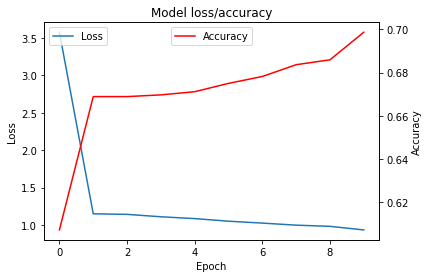

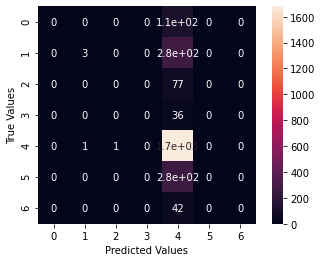

In [167]:
plot_accuracy_epochs(history)

# Generate the confusion matrix and visualize the results
cm = confusion_matrix(y_test, y_pred)
print_confusion_matrix(cm)

From the printed results it appear that the model had initially a high value with respect to the loss that rapidly decreased, in fact the value dropped significantly in the first epoch while in the later ones it seems to have a constant dicreasing behaviour. In contrast, the accuracy of the model has an increasing behaviour even in the last epoch and this suggests that we should have let the model train longer. Furthermore, by visualizing the confusion matrix it appears that the model is faulty is several scenarios. Particularly we can see how the 0th, 1st and 5h category are often mistakenly classified as category 4.

## Enhancements: how to improve the system's performance

### Data Augmentation

One way to improve the system could be to generate more artificial data from the images that are already contained in the dataset. We can simply achieve this goal by using the class ImageDataGenerator of the keras library.

In [161]:
data_generator = ImageDataGenerator(rotation_range=10,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest',
                                   )
data_generator.fit(X_train)

In [ ]:
history_aug = model.fit(data_generator.flow(X_train, y_train), batch_size=100, epochs=10, verbose=1)

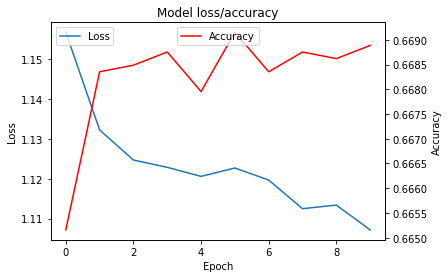

In [170]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)

plot_accuracy_epochs(history_aug)

# UNCOMMENT TO SAVE THE MODEL

# save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
# model.save(os.path.join(save_path, 'naive_augmented_CNN.h5'))

From the results, it appears that the model didn't improve its score althought the accuracy seems to increase at each epoch apart from the two dips at the 4th and 6th epoch. In this case, the model should be trained longer to see if there will be a huge step in terms of performances or if the model stops learning soon after it reaches the accuracy score of 67%.

Below, we can also see how the two models are not different in terms of performances

In [223]:
naive_model = load_model(os.path.join(save_path, 'naive_CNN.h5'))
y_pred_naive = naive_model.predict(X_test)
y_pred_naive = np.argmax(y_pred_naive, axis=1)
cm_naive = confusion_matrix(y_test, y_pred_naive)

naive_aug_model = load_model(os.path.join(save_path, 'naive_augmented_CNN.h5'))
y_pred_naive_aug = naive_aug_model.predict(X_test)
y_pred_naive_aug = np.argmax(y_pred_naive_aug, axis=1)
cm_naive_aug = confusion_matrix(y_test, y_pred_naive_aug)

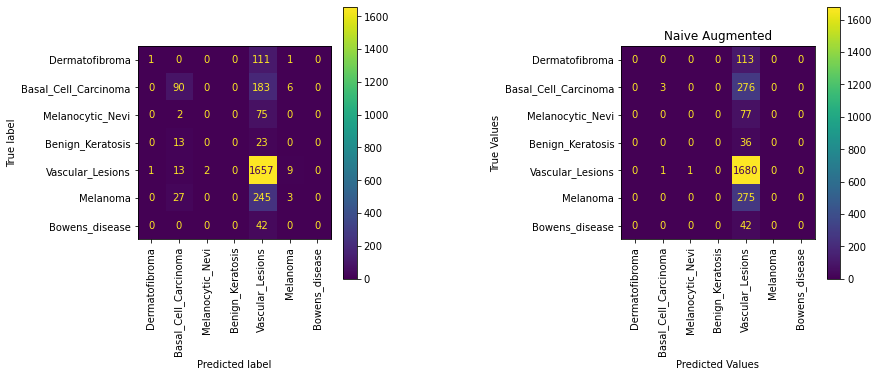

In [266]:
conf_matrices = [cm_naive, cm_naive_aug]
print_confusion_matrix(conf_matrices)

## More enhancements: more layers, regularization, early stop.

In [ ]:
# implement regularization techniques
# implement a monitor with stopping criterion
# try to change the architecture so that it predicts around 90/95%